In [35]:
import torch.nn as nn
import torch
import process_data
import matplotlib.pyplot as plt

In [36]:
class SkipConnection(nn.Module):
    def __init__(self, layer):
        super(SkipConnection, self).__init__()
        self.model = layer
    def forward(self, x, skip):
        x = self.model(x)
        return torch.cat([x, skip], 1)

In [37]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        [
         self.input,
         self.down1,
         self.down2,
         self.down3,
         self.down4,
         self.down5,
         self.down6,
         self.down7
        ] = self.__get_encoder__()
        [self.up1,
         self.up2,
         self.up3,
         self.up4,
         self.up5,
         self.up6,
         self.up7
        ] = self.__get_decoder__()
        self.outermost = nn.Sequential(nn.ReLU(True), 
                                       nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1), 
                                       nn.Tanh()
                                       )
        
    def __get_encoder__(self):
        return [
            UNet.down(input=3, out=64, batch_norm=False),
            UNet.down(input=64, out=128),
            UNet.down(input=128, out=256),
            UNet.down(input=256, out=512),
            UNet.down(input=512, out=512),
            UNet.down(input=512, out=512),
            UNet.down(input=512, out=512),
            UNet.down(input=512, out=512)
        ]
    def __get_decoder__(self):
        return [
            SkipConnection(UNet.up(input=512, out=512)),
            SkipConnection(UNet.up(input=1024, out=512)),
            SkipConnection(UNet.up(input=1024, out=512)),
            SkipConnection(UNet.up(input=1024, out=512)),
            SkipConnection(UNet.up(input=1024, out=256)),
            SkipConnection(UNet.up(input=512, out=128)),
            SkipConnection(UNet.up(input=256, out=64))
        ]
    
    @staticmethod
    def up(input, out, dropout=False):
        upsample = [
            nn.ConvTranspose2d(in_channels=input, out_channels=out, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out),
            nn.ReLU(True)]
        if dropout:
            upsample.append(nn.Dropout2d(0.5))
        return nn.Sequential(*upsample)
    
    @staticmethod
    def down(input, out, batch_norm = True):
        downsample = [
            nn.Conv2d(in_channels=input, out_channels=out, kernel_size=4, stride=2, padding=1),
        ]
        if batch_norm:
            downsample.append(nn.BatchNorm2d(out))
        downsample.append(nn.LeakyReLU(0.2, True))
        return nn.Sequential(*downsample)


    def forward(self, x):
        d1 = self.input(x) #(input=3, out=64,
        d2 = self.down1(d1)  #(input=64, out=128)
        d3 = self.down2(d2)  #(input=128, out=256)
        d4 = self.down3(d3)  #(input=256, out=512)
        d5 = self.down4(d4)  #(input=512, out=512)
        d6 = self.down5(d5)  #(input=512, out=512)
        d7 = self.down6(d6)  #(input=512, out=512)
        d8 = self.down7(d7)  #(input=512, out=512)
        
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.outermost(u7)
        return u8

In [3]:
dataset = process_data.ImageDataset(process_data.Pix2PixDataset.FACADES)
dataset.load_dataset()

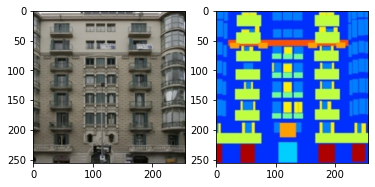

In [12]:
dataset.get_image_paths()
img = dataset.__getitem__(1)
fig = plt.figure()
fig1 = fig.add_subplot(1, 2, 1)
fig1.imshow(img['x'].permute(1, 2, 0))
fig2 = fig.add_subplot(1, 2, 2)
fig2.imshow(img['y'].permute(1, 2, 0))
plt.show()

In [32]:
generator = UNet()
generator.eval()

UNet(
  (input): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [18]:
input_image = img['x']
input_image.shape
input_image = input_image.reshape(1, 3, 256, 256)

In [19]:
xs = torch.stack([torch.randn(3, 256, 256)])
xs.shape

torch.Size([1, 3, 256, 256])

In [33]:
output = generator(input_image)